#Importing libraries and dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import keras.backend as K
import warnings
from sklearn.utils import compute_class_weight
import pywt

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/Chest X-Ray image dataset

In [ ]:
!pip install unrar
!unrar x /content/drive/MyDrive/Covid_mrinal/CovidXRay.rar

Streaming output truncated to the last 5000 lines.
Extracting  Chest X-Ray image dataset/Normal/Normal-6710.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6711.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6712.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6713.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6714.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6715.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6716.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6717.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6718.png              75%  OK 
Extracting  Chest X-Ray image dataset/Normal/Normal-6719.png              75%  OK 
Extracting  Chest X-Ray image

#Loading main dataset

In [ ]:
images = []
classes_labels = []
for i in os.listdir("/content/Chest X-Ray image dataset"):
  class_path = f"/content/Chest X-Ray image dataset/{i}"
  for j in os.listdir(class_path):
    file_path = f"{class_path}/{j}"
    classes_labels.append(i)
    images.append(cv2.resize(cv2.imread(file_path, 1), (224, 224)))

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(images, classes_labels, test_size = 0.2, random_state = 42)

In [ ]:
# train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
# train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [ ]:
len(train_images)

16932

#Upsampling dataset

In [ ]:
covid = []
lung_opacity = []
normal = []
viral_pneumonia = []
for i,j in list(zip(train_images, train_labels)):
  if j == "COVID":
    covid.append(i)
  elif j == "Lung opacity":
    lung_opacity.append(i)
  elif j == "Normal":
    normal.append(i)
  elif j == "Viral Pneumonia":
    viral_pneumonia.append(i)

In [ ]:
covid = np.asarray(covid)
lung_opacity = np.asarray(lung_opacity)
normal = np.asarray(normal)
viral_pneumonia = np.asarray(viral_pneumonia)

In [ ]:
print(f"COVID : {covid.shape}\tLung Opacity : {lung_opacity.shape}\tNormal : {normal.shape}\tViral Pneumonia : {viral_pneumonia.shape}")

COVID : (2850, 224, 224, 3)	Lung Opacity : (4831, 224, 224, 3)	Normal : (8180, 224, 224, 3)	Viral Pneumonia : (1071, 224, 224, 3)


In [ ]:
covid_selected = covid[np.random.choice(covid.shape[0], size=2678)]
lung_opacity_selected = lung_opacity[np.random.choice(lung_opacity.shape[0], size=524)]
normal_selected = normal[np.random.choice(normal.shape[0], size=normal.shape[0] - 2825)]
viral_pneumonia_selected = viral_pneumonia

In [ ]:
print(f"COVID : {covid_selected.shape}\tLung Opacity : {lung_opacity_selected.shape}\tNormal : {normal_selected.shape}\tViral Pneumonia : {viral_pneumonia_selected.shape}")

COVID : (2678, 224, 224, 3)	Lung Opacity : (524, 224, 224, 3)	Normal : (5355, 224, 224, 3)	Viral Pneumonia : (1071, 224, 224, 3)


In [ ]:
def clahe(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    bgr = bgr.astype(np.float32)/255
    return bgr

In [ ]:
def claheInt(image,cliplimit,gridsize):

    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    # bgr = bgr.astype('float32')/255
    return bgr

In [ ]:
def svdstdwithoutdecompostionC(imageA):
  image = imageA
  image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  target_im = cv2.imread('/content/Chest X-Ray image dataset/COVID/COVID-32.png')
  target_im = cv2.cvtColor(target_im, cv2.COLOR_RGB2GRAY)
  st = np.std(image)
  st1 = np.std(target_im)
  mean  =np.mean(image)
  mean1 = np.mean(target_im)
  c = st/mean
  c1 = st1/mean1
  if c1 > c:
    ratio = 1.05 + ((c1-c)/(c1+c))
  else:
  #  print("Original image contrast is better than the target image")
   ratio = 1.05
  u1, s1, v1 = np.linalg.svd(target_im)
  u2, s2, v2 = np.linalg.svd(image)
  s2_new= ratio * s2
  cmpimg = np.matrix(u2[:,:],dtype=np.float32) * np.diag(s2_new[:]) * np.matrix(v2[:,:],dtype=np.float32)
  final_img = cmpimg
  final_img = np.array(final_img, dtype=np.float32)
  # cv2_imshow(final_img)
  final_img  = cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB) / 255
  final_img = NormalizeData(final_img)
  # final_img = final_img.astype(dtype=np.float16)/255
  return final_img

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

##Upsampling COVID

In [ ]:
# test_images = test_images.astype(np.float32) / 255

In [ ]:
covid_clahe_point_5 = [clahe(x, 0.5, 8) for x in covid_selected]

In [ ]:
covid_final = []
for i in covid_clahe_point_5:
  covid_final.append(i)
for i in covid_selected:
  covid_final.append(i.astype(np.float32)/255)

In [ ]:
covid_final.pop()

array([[[0.04705882, 0.04705882, 0.04705882],
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        ...,
        [0.09411765, 0.09411765, 0.09411765],
        [0.09803922, 0.09803922, 0.09803922],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.07058824, 0.07058824, 0.07058824],
        [0.05490196, 0.05490196, 0.05490196],
        [0.02745098, 0.02745098, 0.02745098],
        ...,
        [0.07843138, 0.07843138, 0.07843138],
        [0.08235294, 0.08235294, 0.08235294],
        [0.09411765, 0.09411765, 0.09411765]],

       [[0.04313726, 0.04313726, 0.04313726],
        [0.02352941, 0.02352941, 0.02352941],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.07843138, 0.07843138, 0.07843138],
        [0.07843138, 0.07843138, 0.07843138],
        [0.08627451, 0.08627451, 0.08627451]],

       ...,

       [[0.09411765, 0.09411765, 0.09411765],
        [0.09019608, 0.09019608, 0.09019608],
        [0.16078432, 0

In [ ]:
len(covid_final)

5355

##Upsampling Viral Pneumonia

In [ ]:
viral_pneumonia_clahe_point_5 = [clahe(x, 0.5, 8) for x in viral_pneumonia_selected]
viral_pneumonia_clahe_1 = [clahe(x, 1, 8) for x in viral_pneumonia_selected]
viral_pneumonia_preprocessed_custom = [svdstdwithoutdecompostionC(x) for x in viral_pneumonia_selected]

In [ ]:
viral_pneumonia_preprocessed_custom_with_clahe_point_5 = [svdstdwithoutdecompostionC(claheInt(x, 0.5, 8)) for x in viral_pneumonia_selected]

In [ ]:
viral_pneumonia_final = []
for i in viral_pneumonia_clahe_point_5:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_clahe_1:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_preprocessed_custom_with_clahe_point_5:
  viral_pneumonia_final.append(i)
for i in viral_pneumonia_selected:
  viral_pneumonia_final.append(i.astype(np.float32)/255)

In [ ]:
del covid_clahe_point_5, covid_selected, covid

In [ ]:
len(covid_final)

5355

In [ ]:
len(viral_pneumonia_final)

5355

In [ ]:
lung_opacity_inter = [clahe(x, 0.5, 8) for x in lung_opacity_selected]
# normal_inter = [clahe(x, 0.5, 8) for x in normal_selected]

In [ ]:
lung_opacity_final = []
for i in lung_opacity:
  lung_opacity_final.append(i.astype(np.float32)/255)
for i in lung_opacity_inter:
  lung_opacity_final.append(i)

In [ ]:
len(lung_opacity_final)

5355

In [ ]:
del lung_opacity_selected, lung_opacity_inter

In [ ]:
X_train = []
Y_train = []
for i in covid_final:
  X_train.append(i)
  Y_train.append("COVID")
for i in lung_opacity_final:
  X_train.append(i)
  Y_train.append("Lung opacity")
for i in viral_pneumonia_final:
  X_train.append(i)
  Y_train.append("Viral Pneumonia")

In [ ]:
len(Y_train)

16065

In [ ]:
del covid_final, lung_opacity_final, viral_pneumonia_final

In [ ]:
normal_final = []
for i in normal_selected:
  normal_final.append(i.astype(np.float32)/255)
# for i in normal_inter:
#   normal_final.append(i)

In [ ]:
len(normal_final)

5355

In [ ]:
for i in normal_final:
  X_train.append(i)
  Y_train.append("Normal")

In [ ]:
del normal_final

In [ ]:
len(X_train)

21420

In [ ]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)

In [ ]:
import pickle 
pickle.dump(lb, open('binarizer.pkl', 'wb'))

In [ ]:
import numpy as np
from PIL import Image

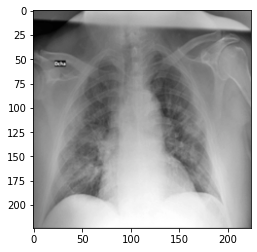

In [ ]:
plt.imshow(X_train[0])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import os

In [ ]:
!rm -rf /content/drive/MyDrive/Covid_mrinal/Equal Processed

In [ ]:
base_path = "/content/drive/MyDrive/Covid_mrinal/Equal Processed"
for i in set(Y_train):
  path = f"{base_path}/{i}"
  try: 
    os.mkdir(path) 
  except OSError as error: 
    print(error)  

In [ ]:
base_path = "/content/drive/MyDrive/Covid_mrinal/Equal Processed"
for i in range(len(X_train)):
  im = np.array(X_train[i])
  plt.imsave(f"{base_path}/{Y_train[i]}/{i}.png", im)
  print(i, end="\t")

In [ ]:
del lb

In [ ]:
X_train = np.array(X_train, dtype=np.float16)

In [ ]:
X_train.shape

#Data Visualization

In [ ]:
def data(history):
  return pd.DataFrame(data=list(zip(history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"], history.history["recall"], history.history["val_recall"], history.history["precision"], history.history["val_precision"], history.history["auc"], history.history["val_auc"], history.history["specificity"], history.history["val_specificity"], history.history["sensitivity"], history.history["val_sensitivity"], history.history["mcc"], history.history["val_mcc"])) , columns=["Accuracy", "Validation Accuracy", "Loss", "Validation Loss", "Recall", "Validation Recall", "Precision", "Validation Precision", "AUC", "Validation AUC", "Specificity", "Validation Specificity" ,"Sensitivity", "Validation Sensitivity", "MCC", "Validation MCC"])

In [ ]:
def history_visualization(df):
  sns.set_style('darkgrid')
  nrow = 4
  ncol = 2
  df_columns = df.columns
  df_list = [df[col] for col in df]
  titles=["Accuracy Visualization", "Loss Visualization", "Recall Visualization", "Precision Visualization", "AUC Visualization", "Specificity Visualization", "Sensitivity Visualization", "MCC Visualization"]
  fig, axes = plt.subplots(nrow, ncol, figsize=(20, 16))
  count = 0
  i = 0
  for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c], x="Number of Epochs", legend="brief", label=df_columns[count], marker="o").set_title(titles[i])
        df_list[count+1].plot(ax=axes[r, c], x="Number of Epochs", legend="brief" ,label=df_columns[count+1], marker="o").set_title(titles[i])
        i+=1
        count+=2

In [ ]:
early_stoping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

#Custom Metrics using Tensorflow

In [ ]:
def true_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.linalg.diag_part(res), axis = 0)

def false_positive(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def false_negative(y_true, y_pred):
  y_true = tf.argmax(y_true)
  y_pred = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true, y_pred, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1) - tf.linalg.diag_part(res), axis = 0)

def true_negative(y_true, y_pred):
  y_true_res = tf.argmax(y_true)
  y_pred_res = tf.argmax(y_pred)
  res = tf.math.confusion_matrix(y_true_res, y_pred_res, dtype=tf.float32)
  return tf.reduce_sum(tf.reduce_sum(res, axis = 1), axis=0) - (false_negative(y_true, y_pred) + false_positive(y_true, y_pred) + true_positive(y_true, y_pred))

In [ ]:
def sensitivity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TP)
    den = float(TP + FN + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

def specificity(y_true, y_pred):
    y_actual = tf.argmax(y_true).numpy()
    y_hat = tf.argmax(y_pred).numpy()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num = float(TN)
    den = float(TN + FP + K.epsilon())
    if den == 0.0:
      return tf.constant(0.0, dtype=tf.float32)
    return tf.constant(float(num/den), dtype=tf.float32)

In [ ]:
def mcc(y_true, y_pred):
  y_true = tf.argmax(y_true).numpy()
  y_pred = tf.argmax(y_pred).numpy()

  return tf.constant(matthews_corrcoef(y_true, y_pred))

#Image Generator

In [ ]:
image_generator = ImageDataGenerator(validation_split = 0.2)

In [ ]:
train_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Equal Processed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="training")

Found 17136 images belonging to 4 classes.


In [ ]:
validation_dataset = image_generator.flow_from_directory(directory="/content/drive/MyDrive/Covid_mrinal/Equal Processed", target_size=(224, 224), color_mode="rgb", class_mode="categorical", shuffle=True, subset="validation")

Found 4284 images belonging to 4 classes.


#VGG19 without class weights



In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model_resnet50 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model_resnet50.trainable = False
# base_model_resnet50.summary()
final_model_resnet50 = keras.models.Sequential([base_model_resnet50, keras.layers.Flatten(), keras.layers.Dense(4, activation="softmax")])
final_model_resnet50.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), specificity, sensitivity, mcc], run_eagerly=True)
resnet50_history = final_model_resnet50.fit(x=train_dataset, validation_data=validation_dataset, epochs=20, batch_size=32, callbacks=[early_stoping])

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/20
536/536 [==============================] - 5021s 9s/step - loss: 2.9979 - accuracy: 0.6383 - precision: 0.8816 - recall: 0.8816 - auc: 0.9341 - specificity: 0.7687 - sensitivity: 0.6157 - mcc: 0.7528 - val_loss: 3.1092 - val_accuracy: 0.7760 - val_precision: 0.9041 - val_recall: 0.9041 - val_auc: 0.9425 - val_specificity: 0.8433 - val_sensitivity: 0.5933 - val_mcc: 0.7929
Epoch 2/20
536/536 [==============================] - 247s 461ms/step - loss: 1.6912 - accuracy: 0.8261 - precision: 0.9425 - recall: 0.9425 - auc: 0.9669 - specificity: 0.9021 - sensitivity: 0.6623 - mcc: 0.8761 - val_loss: 2.1529 - val_accuracy: 0.8541 - val_precision: 0.9400 - val_recall: 0.9400 - val_auc: 0.9644 - val_specificity: 0.9291 - val_sensitivity: 0.6194 - val_mcc: 0.8960
Epoch 3/20
536/536 [==============================] - 247s 461ms/step - loss: 1.0811 - accuracy: 0.8729 - precision: 0.9599 - recall: 0.9599 - auc: 0.9778 - spec

In [ ]:
df = data(resnet50_history)

In [ ]:
df

,Accuracy,Validation Accuracy,Loss,Validation Loss,Recall,Validation Recall,Precision,Validation Precision,AUC,Validation AUC,Specificity,Validation Specificity,Sensitivity,Validation Sensitivity,MCC,Validation MCC
0,0.638262,0.776027,2.997858,3.109208,0.881594,0.904062,0.881646,0.904062,0.934076,0.942472,0.768657,0.843284,0.615672,0.593284,0.752843,0.792910
1,0.826053,0.854108,1.691196,2.152865,0.942519,0.940009,0.942519,0.940009,0.966851,0.964427,0.902052,0.929104,0.662313,0.619403,0.876088,0.895997
2,0.872943,0.880777,1.081069,2.594921,0.959909,0.941176,0.959909,0.941176,0.977805,0.965316,0.896455,0.873134,0.660448,0.611940,0.900771,0.848880
3,0.905914,0.916608,0.845821,2.041912,0.968546,0.957750,0.968546,0.957750,0.982097,0.975973,0.940298,0.936567,0.686567,0.652985,0.924559,0.920398
4,0.921860,0.894783,0.629404,3.062206,0.975082,0.936741,0.975082,0.936741,0.986018,0.961165,0.955224,0.910448,0.706157,0.641791,0.940920,0.869403
5,0.937923,0.931314,0.534778,2.605959,0.980859,0.955415,0.980859,0.955415,0.989145,0.972752,0.966418,0.906716,0.713619,0.697761,0.958489,0.909826
6,0.943044,0.928455,0.664833,4.501493,0.978408,0.936975,0.978408,0.936975,0.987848,0.960563,0.968283,0.902985,0.711754,0.634328,0.954291,0.848880
7,0.955664,0.945028,0.577949,2.826261,0.983193,0.957516,0.983193,0.957516,0.990487,0.973731,0.975746,0.932836,0.671642,0.597015,0.958489,0.899254
8,0.958319,0.936041,0.638172,4.938641,0.982610,0.937442,0.982610,0.937442,0.989675,0.960692,0.964552,0.906716,0.711754,0.589552,0.955342,0.866293


In [ ]:
df.to_csv("resnet50_best_model_30k.csv")

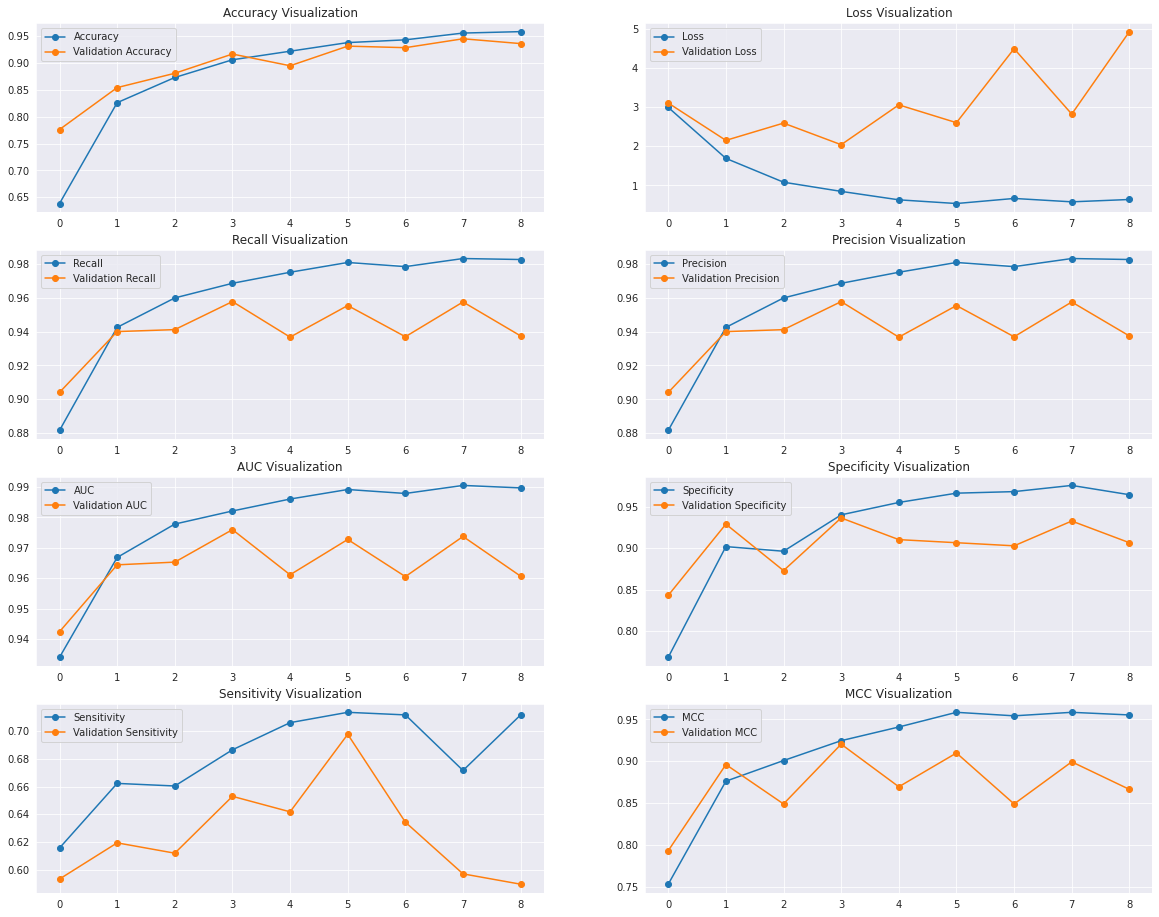

In [ ]:
history_visualization(df)

In [ ]:
final_model_resnet50.save("/content/drive/MyDrive/COVID/resnet_model_best_30k.h5")

In [ ]:
final_model_resnet50.save_weights("/content/drive/MyDrive/COVID/resnet_model_best_30k_weights.h5")

In [ ]:
train_dataset.class_indices

{'COVID': 0, 'Lung opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
predictions = final_model_resnet50.predict(test_images)
predictions_index = np.argmax(predictions, axis = -1)
test_labels_index = np.vectorize(train_dataset.class_indices.get)(test_labels)
print(classification_report(predictions_index, test_labels_index))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       670
           1       0.93      0.87      0.90      1271
           2       0.92      0.95      0.94      2018
           3       1.00      0.96      0.98       274

    accuracy                           0.93      4233
   macro avg       0.95      0.94      0.94      4233
weighted avg       0.93      0.93      0.93      4233



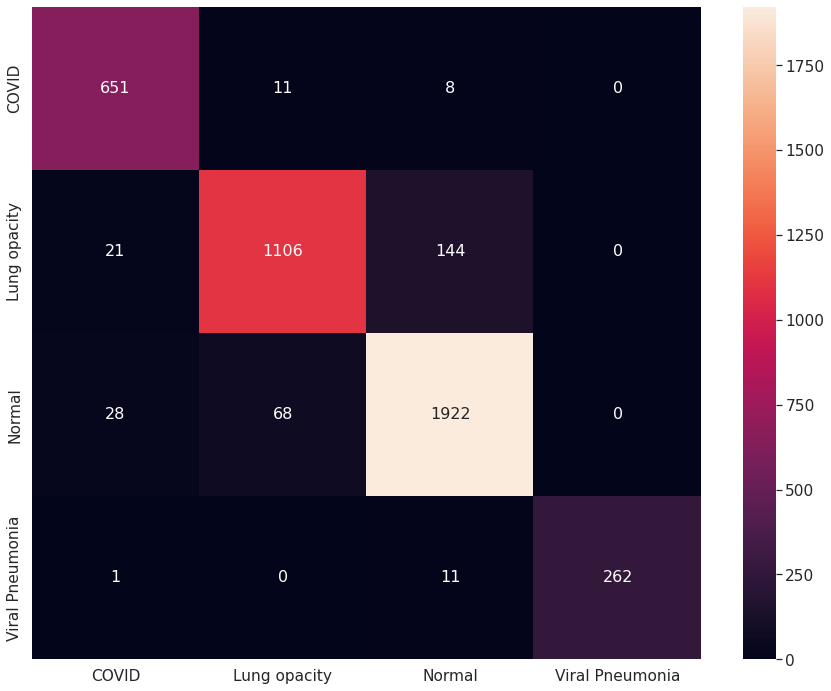

In [ ]:
plt.figure(figsize=(15, 12))
cm = confusion_matrix(predictions_index, test_labels_index)
df_cm = pd.DataFrame(cm, index = [i for i in train_dataset.class_indices],
                  columns = [i for i in train_dataset.class_indices])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') 
plt.show()